# 01_Split_Videos.ipynb

Original code from Carolyn Parkinson & modified for personal use

Creates fslroi command to split whole run into individual videos

Input: 

* Run Ref File
    
    *  /Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/239_run_ref.csv
   
* Run File
    
Output: 
   
* Video run file

In [5]:
import os
import subprocess
import pandas as pd

from nilearn import input_data
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# define a function to execute shell commands
def sh(c):
    '''
    run shell commands
    '''
    subprocess.call(c, shell = True)
    
import math

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

In [15]:
sub = "289"
subject = "sub-" + sub

data_filepath = os.path.join("/Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/", subject)
run_ref_filepath = "/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/" + sub + "_run_ref.csv"

run_ref = pd.DataFrame.from_csv(run_ref_filepath)
run_ref = run_ref[run_ref.run == 1]
run_ref


#video_start_time = [11, 148, 285, 421]
#video_start_tr = [round_up_to_even(x)/2 + 3 - start for x in video_start_time]
#video_start_tr


,sub_id,trial,video_number,self_other,neg_pos,scan_start,video_start,video_start_rts,run
0,289.0,1.0,11.0,other,pos,8213.23022,8224.863365,11.633145,1.0
1,289.0,2.0,13.0,other,pos,8213.23022,8361.555355,148.325135,1.0
2,289.0,3.0,3.0,self,neg,8213.23022,8498.510094,285.279874,1.0
3,289.0,4.0,6.0,self,neg,8213.23022,8635.087135,421.856916,1.0


In [ ]:
for index, video in enumerate([11, 13, 3, 6]): 

    run_filename = "sub-289_task-emp_run-01_bold.nii"
    bold_input_filename = os.path.join(data_filepath, run_filename)

    video_filename = ("video_{video}.nii.gz").format(video=str(video))
    bold_output_filename = os.path.join(data_filepath, video_filename)

    start = video_start_tr[index]
    duration = 60

    sh_cmd = ("""fslroi \
          {bold_input_filename}\
          {bold_output_filename}\
          {start}\
          {duration}""").format(bold_input_filename=bold_input_filename, bold_output_filename=bold_output_filename, start=start, duration=duration)
    sh(sh_cmd)
    print(sh_cmd)

In [174]:
for video in [11, 13, 3, 6]: 
    print(video)

11
13
3
6


(80, 80, 46, 273)
(80, 80, 46, 250)
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x11e213da0>, <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x12a37df60>, 
{ 'allow_overlap': False,
  'detrend': True,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(46, 1, 20), (-60, 3, 18)],
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2}, confounds=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=1, verbose=1)
[NiftiSpheresMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(80, 80, 46, 250),
affine=array([[   2.9000001 ,    0.        ,    0.        , -121.87900543],
       [   0.        ,    2.9000001 ,    0.        , -117.50000763],
       [   0.    
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheres

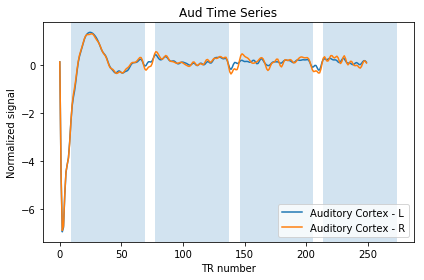

In [170]:
#Load original and cut data
#bold_input = image.smooth_img(bold_input_filename, fwhm=3)
#bold_output= image.smooth_img(bold_output_filename, fwhm=3)

print(bold_input.shape)
print(bold_output.shape)

#Guess auditiory cortex seed
#aud_coords = [(46,1,20),(-60,3,18), (-19,-73,-30)]
aud_coords = [(46,1,20),(-60,3,18)]
#labels = ['Audtiory Cortex?', 'Audtiory Cortex2?', 'Visual Cortex?']
labels = ['Auditory Cortex - L', 'Auditory Cortex - R']

masker = input_data.NiftiSpheresMasker(
    aud_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=1)

time_series = masker.fit_transform(bold_output)

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)
    
    
plt.axvspan(video_start[0],video_start[0]+60, alpha =.2)
plt.axvspan(video_start[1],video_start[1]+60, alpha =.2)
plt.axvspan(video_start[2],video_start[2]+60, alpha =.2)
plt.axvspan(video_start[3],video_start[3]+60, alpha =.2)

plt.title('Aud Time Series')
plt.xlabel('TR number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()

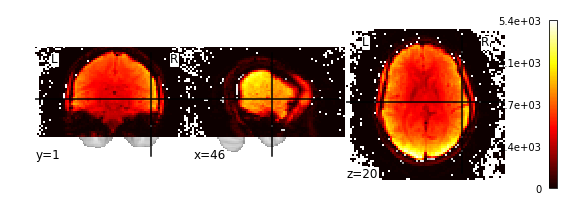

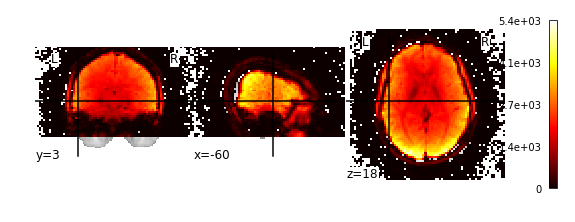

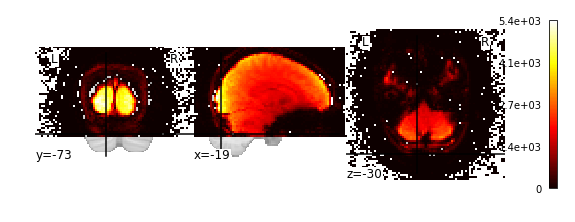

In [158]:
from nilearn import image
from nilearn import plotting

first_rsn = image.index_img(bold_output_filename, 0)

plotting.plot_stat_map(first_rsn, cut_coords=aud_coords[0])
plotting.plot_stat_map(first_rsn, cut_coords=aud_coords[1])
plotting.plot_stat_map(first_rsn, cut_coords=aud_coords[2])

In [100]:
z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show

display = plot_anat(bold_input, display_mode='z', cut_coords=[z_slice],
                    figure=fig)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.


Dataset created in /Users/mdclark/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 291168628 of 291168628 bytes (100.0%,    0.0s remaining) ...done. (55 seconds, 0 min)
Extracting data from /Users/mdclark/nilearn_data/haxby2001/f33ff337e914bf7fded743c7107979f9/subj2-2010.01.14.tar.gz..... done.


First subject anatomical nifti image (3D) is at: /Users/mdclark/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is at: /Users/mdclark/nilearn_data/haxby2001/subj2/bold.nii.gz


/Users/mdclark/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/mdclark/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/mdclark/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'contours'
  s)


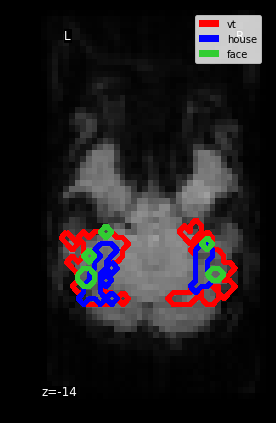

In [87]:
import matplotlib.pyplot as plt

from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is at: %s' %
      haxby_dataset.func[0])  # 4D data

# Build the mean image because we have no anatomic data
from nilearn import image
func_filename = haxby_dataset.func[0]
mean_img = image.mean_img(func_filename)

z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show
display = plot_anat(mean_img, display_mode='z', cut_coords=[z_slice],
                    figure=fig)
mask_vt_filename = haxby_dataset.mask_vt[0]
mask_house_filename = haxby_dataset.mask_house[0]
mask_face_filename = haxby_dataset.mask_face[0]
display.add_contours(mask_vt_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['red'])
display.add_contours(mask_house_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['blue'])
display.add_contours(mask_face_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['limegreen'])

# We generate a legend using the trick described on
# http://matplotlib.sourceforge.net/users/legend_guide.httpml#using-proxy-artist
from matplotlib.patches import Rectangle
p_v = Rectangle((0, 0), 1, 1, fc="red")
p_h = Rectangle((0, 0), 1, 1, fc="blue")
p_f = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"])

show()